# What Makes A Best Original Screenplay?

    By Allison Ragan and Allison Shafer
    American University
    STAT-696 Applied Natural Language Processing

# Analysis

# Table of Contents

    I. Package Imports
    II. NLP Transformations
        i. CountVectorized
        ii. TFIDF
    III. Sentiment Analysis
        i. Sentiment Analysis -- Dialogue
        ii. Sentiment Analysis -- Full Script
    IV. Topic Modeling
        i. Topic Modeling -- Dialogue
        ii. Topic Modeling -- Full Script
    V. K-Means Clustering
        i. K-Means Clustering -- Dialogue
        ii. K-Means Clustering -- Full Script
    VI. Results

## Package Imports

In [197]:
import pandas as pd 
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import NMF as nmf
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import wordcloud # may need to install
from plotnine import * # may need to install; ggplot included
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from afinn import Afinn


In [15]:
# Read in .csv to dataframe

movies_df = pd.read_csv('./movies_df.csv')

## Data Visualizations

## Prep Data for Analysis


In [16]:
# Created grouped data

Genres_df = movies_df.groupby(["GenresBroad"])

Win_Lose = movies_df.groupby('orig_screen_win')

# sanity check on grouping
Genres_df.agg({'dialogue_length':sum})

Win_Lose.agg({'dialogue_length':sum})


# Group text by Genre for analysis
text_group_genre = Genres_df['cleaned_dialogue'].apply(' '.join).reset_index()

text_group_genre = pd.DataFrame(text_group_genre)

# Group text by winner/loser for analysis

win_lose_text = Win_Lose['cleaned_dialogue'].apply(' '.join).reset_index()

## NLP transformations

### CV

In [17]:
# instantiate

# all scripts and visuals 
bow_all = CountVectorizer(ngram_range=(1,2), max_df = .85, min_df = 2)
# fit + transform training data
bow_all_fit = bow_all.fit_transform(movies_df['cleaned_script'])

# for dialogue only
bow_dialogue = CountVectorizer(ngram_range=(1,2), max_df = .85, min_df = .2)
# fit + transform training data
bow_dialogue_fit = bow_dialogue.fit_transform(movies_df['cleaned_dialogue'])

### TFIDF

In [177]:
# instantiate - All parts of script
tfidf_all = TfidfVectorizer(ngram_range = (1,2), max_df = .8, min_df = .2, stop_words = 'english')

# fit + transform training data - all scripts and visuals

tfidf_all_fit = tfidf_all.fit_transform(movies_df['cleaned_script'])
tfidf_vocab_all = tfidf_all.vocabulary_
tfidf_vocab_all = {k: v for k, v in sorted(tfidf_vocab_all.items(), key=lambda item: item[1], reverse=True)}
print(tfidf_vocab_all)
len(tfidf_vocab_all)


# instantiate - Dialogue Only
tfidf_dialogue = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = .2, stop_words = 'english')

# fit + transform training data - dialogue only 
tfidf_dialogue_fit = tfidf_dialogue.fit_transform(movies_df['cleaned_dialogue'])
tfidf_vocab_dialogue = tfidf_dialogue.vocabulary_
tfidf_vocab_dialogue = {k: v for k, v in sorted(tfidf_vocab_dialogue.items(), key=lambda item: item[1], reverse=True)}
print(tfidf_vocab_dialogue)
len(tfidf_vocab_dialogue)

{'zone': 3640, 'zero': 3639, 'yup': 3638, 'youve': 3637, 'youre right': 3636, 'youre going': 3635, 'youre': 3634, 'younger': 3633, 'young woman': 3632, 'young man': 3631, 'youll': 3630, 'youd': 3629, 'york city': 3628, 'york': 3627, 'yesterday': 3626, 'yes yes': 3625, 'yes think': 3624, 'yes thank': 3623, 'yes sir': 3622, 'yes know': 3621, 'yes int': 3620, 'yes course': 3619, 'yep': 3618, 'yellow': 3617, 'yelling': 3616, 'yell': 3615, 'yearold': 3614, 'year old': 3613, 'year later': 3612, 'year ago': 3611, 'yeah yeah': 3610, 'yeah thats': 3609, 'yeah sure': 3608, 'yeah sorry': 3607, 'yeah right': 3606, 'yeah okay': 3605, 'yeah mean': 3604, 'yeah like': 3603, 'yeah know': 3602, 'yeah int': 3601, 'yeah guess': 3600, 'yeah got': 3599, 'yeah good': 3598, 'yeah gon': 3597, 'yay': 3596, 'yawn': 3595, 'yard away': 3594, 'yard': 3593, 'yank': 3592, 'wrote': 3591, 'written': 3590, 'writing': 3589, 'writes': 3588, 'writer': 3587, 'write': 3586, 'wrist': 3585, 'wrestling': 3584, 'wrapping': 3583,

{'zero': 2817, 'yup': 2816, 'youve': 2815, 'youre going': 2814, 'youre': 2813, 'younger': 2812, 'young woman': 2811, 'young man': 2810, 'youll': 2809, 'youd': 2808, 'york city': 2807, 'york': 2806, 'yesterday': 2805, 'yes yes': 2804, 'yes think': 2803, 'yes thank': 2802, 'yes sorry': 2801, 'yes sir': 2800, 'yes know': 2799, 'yes good': 2798, 'yes course': 2797, 'yep': 2796, 'yellow': 2795, 'yelling': 2794, 'yell': 2793, 'yearold': 2792, 'year old': 2791, 'year ago': 2790, 'yeah yeah': 2789, 'yeah sorry': 2788, 'yeah right': 2787, 'yeah need': 2786, 'yeah mean': 2785, 'yeah like': 2784, 'yeah know': 2783, 'yeah guess': 2782, 'yeah got': 2781, 'yeah good': 2780, 'yeah gon': 2779, 'yeah fuck': 2778, 'yard': 2777, 'yank': 2776, 'wrote': 2775, 'wrong': 2774, 'written': 2773, 'writing': 2772, 'writes': 2771, 'writer': 2770, 'write': 2769, 'wrist': 2768, 'wrestling': 2767, 'wrapping': 2766, 'wrapped': 2765, 'wrap': 2764, 'wow': 2763, 'wounded': 2762, 'wound': 2761, 'wouldnt': 2760, 'worth': 2

2818

# Sentiment Analysis

Using AFINN lexicon, aka the "new ANEW" which calculates a polarity score associated with each word.


### Sentiment Analysis -- Dialogue

In [7]:
# initialize afinn sentiment analyzer
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in list(movies_df['cleaned_dialogue'])]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

afinn_dialogue = pd.DataFrame([list(movies_df['Title']), list(movies_df['Genres']), list(movies_df['GenresBroad']), list(movies_df['orig_screen_win']), sentiment_scores, sentiment_category]).T
afinn_dialogue.columns = ['Titles', 'Genres', 'GenresBroad', 'Winner', 'SentimentScore', 'SentimentCategory']
afinn_dialogue['SentimentScore'] = afinn_dialogue['SentimentScore'].astype('float')

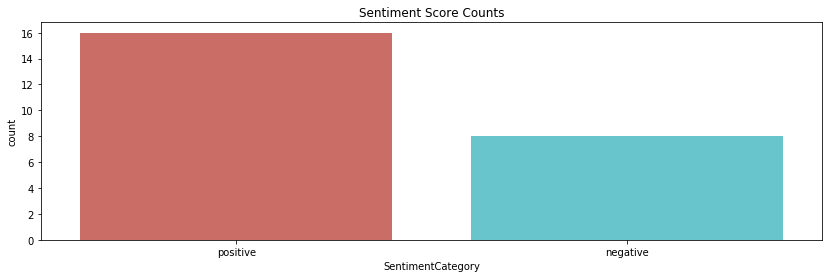

In [8]:
plt.figure(figsize=(14,4))
sns.countplot(x='SentimentCategory', data=afinn_dialogue, palette="hls").set_title("Sentiment Score Counts")
plt.show()

#### Winners vs Losers

In [9]:
# sentiment statistics for winners/losers
afinn_dialogue.groupby(by=['Winner']).describe()

SentimentScore                                                       \
                count        mean         std     min    25%    50%    75%   
Winner                                                                       
0                19.0   96.578947  490.590043 -1044.0 -150.5  170.0  384.0   
1                 5.0  132.400000  151.640364   -24.0   21.0   89.0  239.0   

               
          max  
Winner         
0       998.0  
1       337.0

Text(0.5, 1.0, 'Boxplot of Sentiment Score by Result')

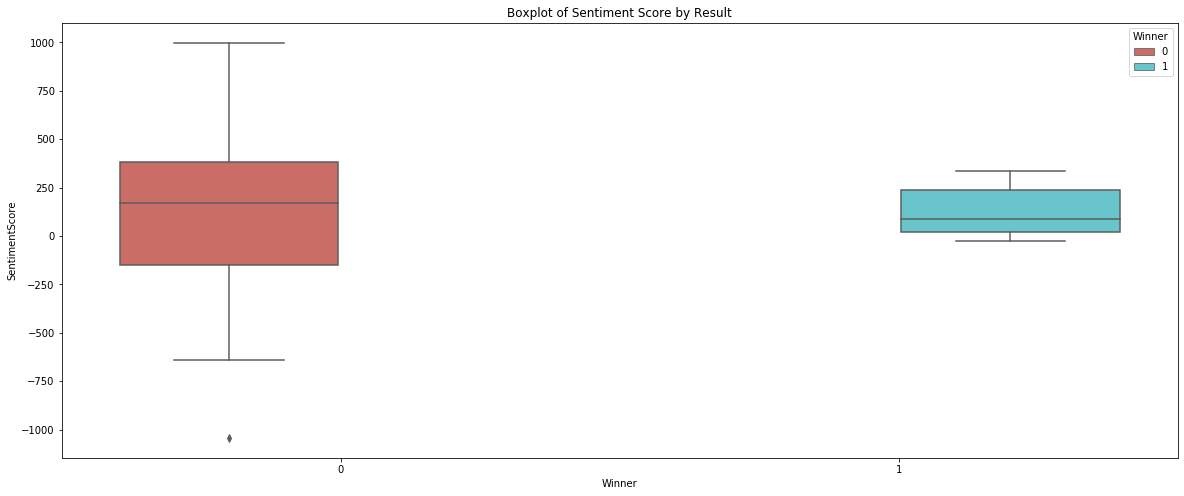

In [10]:
# boxplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x='Winner', y="SentimentScore", 
                 hue='Winner', data=afinn_dialogue, ax=ax,
                 palette="hls").set_title('Boxplot of Sentiment Score by Result')

In [ ]:
# barplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = "Winner", y = "SentimentScore", ax=ax, data=afinn_dialogue, 
            palette="hls", ci=None).set_title('Bar Plot of Sentiment Score by Result')

In [ ]:
# countplot
fig_dims = (20, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y="Winner", hue="SentimentCategory", data=afinn_dialogue, 
              ax=ax, palette="hls").set_title('Count Plot of Sentiment Score by Result')

### Sentiment Analysis -- Full Script

In [ ]:
# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in list(movies_df['cleaned_script'])]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

afinn_all = pd.DataFrame([list(movies_df['Title']), list(movies_df['Genres']), list(movies_df['GenresBroad']), list(movies_df['orig_screen_win']), sentiment_scores, sentiment_category]).T
afinn_all.columns = ['Titles', 'Genres', 'GenresBroad', 'Winner', 'SentimentScore', 'SentimentCategory']
afinn_all['SentimentScore'] = afinn_all['SentimentScore'].astype('float')

## Topic Modeling -- AS

### TFIDF/ NMF

### Topic Modeling -- Dialogue

In [32]:
# instantiate
tfidf_dialogue = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = .2, stop_words = 'english')

# fit + transform training data - dialogue only 
tfidf_dialogue_fit = tfidf_dialogue.fit_transform(movies_df['cleaned_dialogue'])
tfidf_vocab_dialogue = tfidf_dialogue.vocabulary_
tfidf_vocab_dialogue = {k: v for k, v in sorted(tfidf_vocab_dialogue.items(), key=lambda item: item[1], reverse=True)}
print(tfidf_vocab_dialogue)

tf_diag_feat = tfidf_dialogue.get_feature_names()
len(tf_diag_feat)

{'zero': 2817, 'yup': 2816, 'youve': 2815, 'youre going': 2814, 'youre': 2813, 'younger': 2812, 'young woman': 2811, 'young man': 2810, 'youll': 2809, 'youd': 2808, 'york city': 2807, 'york': 2806, 'yesterday': 2805, 'yes yes': 2804, 'yes think': 2803, 'yes thank': 2802, 'yes sorry': 2801, 'yes sir': 2800, 'yes know': 2799, 'yes good': 2798, 'yes course': 2797, 'yep': 2796, 'yellow': 2795, 'yelling': 2794, 'yell': 2793, 'yearold': 2792, 'year old': 2791, 'year ago': 2790, 'yeah yeah': 2789, 'yeah sorry': 2788, 'yeah right': 2787, 'yeah need': 2786, 'yeah mean': 2785, 'yeah like': 2784, 'yeah know': 2783, 'yeah guess': 2782, 'yeah got': 2781, 'yeah good': 2780, 'yeah gon': 2779, 'yeah fuck': 2778, 'yard': 2777, 'yank': 2776, 'wrote': 2775, 'wrong': 2774, 'written': 2773, 'writing': 2772, 'writes': 2771, 'writer': 2770, 'write': 2769, 'wrist': 2768, 'wrestling': 2767, 'wrapping': 2766, 'wrapped': 2765, 'wrap': 2764, 'wow': 2763, 'wounded': 2762, 'wound': 2761, 'wouldnt': 2760, 'worth': 2

2818

In [33]:
n_dialogue = nmf(n_components = 10).fit(tfidf_dialogue_fit) # set up nmf model for 10 topics - one for each movie?

# function to marry up word value to feature names and output words per topic
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(n_dialogue, tf_diag_feat, 10) # 20 words per topic



# n = nmf(n_components = 24).fit(tfidf_dialogue_fit) # set up nmf model for 24 topics - one for each movie?

# # function to marry up word value to feature names and output words per topic
# def print_top_words(model, feature_names, n_top_words): 
#     for topic_idx, topic in enumerate(model.components_):
#         message = "Topic %d: " % topic_idx
#         message += " ".join([feature_names[i]
#                              for i in topic.argsort()[:-n_top_words - 1:-1]])
#         print(message)
#     print()

# print_top_words(n, tf_diag_feat, 20)


Topic 0: beat sir nod sign pie egg blood grab german corridor
Topic 1: dont youre thats shes david didnt whats doesnt dont know ill
Topic 2: gon fucking bank fuck beth god wan cube pause cop
Topic 3: dick power president mary agent mike war american office state
Topic 4: lady bird mom dad suddenly nod shall horse rabbit dress
Topic 5: charlie new york york theater mom fucking lawyer hesitates pause envelope
Topic 6: los sofa patio doctor hall pie van dice child nurse
Topic 7: joy sadness memory island dad thats dont fear mom train
Topic 8: rose rod picture brooklyn driver dont lawn dining jim richard
Topic 9: lip piano christmas glance record gon george hell stage letter



### Topic Modeling -- Full Script

In [74]:
# instantiate
tfidf_all = TfidfVectorizer(ngram_range = (1,2), max_df = .8, min_df = .20, stop_words = 'english')

# fit + transform training data - all scripts and visuals
tfidf_all_fit = tfidf_all.fit_transform(movies_df['cleaned_script'])
#tfidf_vocab_all = tfidf_all_fit.vocabulary_
tfidf_vocab_all = {k: v for k, v in sorted(tfidf_vocab_all.items(), key=lambda item: item[1], reverse=True)}
print(tfidf_vocab_all)


tf_all_feat = tfidf_all.get_feature_names()
len(tf_all_feat)

{'zone': 3640, 'zero': 3639, 'yup': 3638, 'youve': 3637, 'youre right': 3636, 'youre going': 3635, 'youre': 3634, 'younger': 3633, 'young woman': 3632, 'young man': 3631, 'youll': 3630, 'youd': 3629, 'york city': 3628, 'york': 3627, 'yesterday': 3626, 'yes yes': 3625, 'yes think': 3624, 'yes thank': 3623, 'yes sir': 3622, 'yes know': 3621, 'yes int': 3620, 'yes course': 3619, 'yep': 3618, 'yellow': 3617, 'yelling': 3616, 'yell': 3615, 'yearold': 3614, 'year old': 3613, 'year later': 3612, 'year ago': 3611, 'yeah yeah': 3610, 'yeah thats': 3609, 'yeah sure': 3608, 'yeah sorry': 3607, 'yeah right': 3606, 'yeah okay': 3605, 'yeah mean': 3604, 'yeah like': 3603, 'yeah know': 3602, 'yeah int': 3601, 'yeah guess': 3600, 'yeah got': 3599, 'yeah good': 3598, 'yeah gon': 3597, 'yay': 3596, 'yawn': 3595, 'yard away': 3594, 'yard': 3593, 'yank': 3592, 'wrote': 3591, 'written': 3590, 'writing': 3589, 'writes': 3588, 'writer': 3587, 'write': 3586, 'wrist': 3585, 'wrestling': 3584, 'wrapping': 3583,

3641

In [75]:
n_tf_all = nmf(n_components = 10).fit(tfidf_all_fit) # set up nmf model for 10 topics

# function to marry up word value to feature names and output words per topic
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
print_top_words(n_tf_all, tf_all_feat, 10)


# n = nmf(n_components = 24).fit(tfidf_all_fit) # set up nmf model for 24 topics

# # function to marry up word value to feature names and output words per topic
# def print_top_words(model, feature_names, n_top_words): 
#     for topic_idx, topic in enumerate(model.components_):
#         message = "Topic %d: " % topic_idx
#         message += " ".join([feature_names[i]
#                              for i in topic.argsort()[:-n_top_words - 1:-1]])
#         print(message)
#     print()
    
# print_top_words(n, tf_all_feat, 10)

Topic 0: contd dont youre thats william shes rose power doesnt george
Topic 1: cont apartment richard script pie party shooting corridor library apartment day
Topic 2: charlie james continuous police station police fucking pause int police cop road
Topic 3: gon bank beth cube mary michael leaning church sigh fucking
Topic 4: lip continued sofa los cont patio tony george doctor italian
Topic 5: david dick bush president hotel waiter manager mary george wood
Topic 6: lady bird cont mom script shooting sister college dad dress
Topic 7: joy sadness memory fear anger mom dad island contd san
Topic 8: mike priest boston joe jim dont church thats law contd
Topic 9: private german soldier captain colonel smith sir dont rifle wire



In [37]:
# Add Topics to dataframe # by dialogue

topic_values = n_dialogue.transform(tfidf_dialogue_fit)
movies_df['Dia_Topic'] = topic_values.argmax(axis = 1)


In [38]:
# Add Topics to dataframe # by full script

topic_values = n_tf_all.transform(tfidf_all_fit)
movies_df['Full_Topic'] = topic_values.argmax(axis = 1)

In [196]:
movies_df

,Unnamed: 0,Title,Script,year,orig_screen_win,best_pic_win,reviewer,cleaned_dialogue,cleaned_script,script_length,dialogue_length,Genres,GenresBroad,Rating,Critic_Score,Aud_Score,RunTime,Dia_Topic,Full_Topic
0,0,First_Reformed,Scripts.com\n\nFirst Reformed\n\nBy Paul Schra...,2018,0,NaN,Ragan,keep journal word program digital file longhan...,bird calling distance toller keep journal word...,4016,3966,Drama,Drama,R,93,68,108,2,3
1,1,GreenBook,GREEN BOOK \n\nWritten by \n\nNick Vallelonga ...,2018,1,Win,Ragan,thank much welcome jules podell copacabana bob...,fade title card new york city 1962 ext copacab...,12048,7363,Drama,Drama,PG-13,78,91,130,9,4
2,2,Hell_or_HighWater,Scripts.com\n\nHell or High Water\n\nBy Taylor...,2016,0,Nom,Ragan,quiet open door open door devil please stand t...,quiet open door open door devil please stand t...,3371,3371,Drama,Mystery Suspense,R,97,88,102,2,3
3,3,LadyBird,\n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \...,2017,0,Nom,Ragan,making bed looking back loan scholarship world...,anybody talk california hedonism never spent c...,9654,5916,Comedy-Drama,Comedy-Drama,R,99,79,93,4,7
4,4,LaLaLand,LA LA LAND\n\nby\n\nDamien Chazelle\n\n A sun-...,2016,0,Nom,Ragan,think going worst working like gon talk talk w...,sunblasted sky hear radio one piece music anot...,9537,6634,Comedy-Drama,Comedy-Drama,PG-13,91,81,128,0,1
5,5,MarriageStory,MARRIAGE STORY\n\nWritten and Directed by Noah...,2019,0,Nom,Ragan,make people feel comfortable even embarrassing...,charlie love nicole int theater manhattan day ...,13890,10127,Drama,Drama,R,95,85,136,5,2
6,6,Roma,IN ENGLISH\n\n ROMA\n\nWritten and Directed by...,2018,0,Nom,Ragan,said bed look mommy grade watermelon cleo coul...,int patio tepeji day yellow triangle inside re...,33940,25151,Drama,Drama,R,95,72,135,6,4
7,7,ShapeofWater,F O R Y O U R C O N S I D E R A T I O N\n\...,2017,0,Win,Ragan,spoke did would tell wonder would tell time ha...,int elisa apartment river footage night float ...,23215,16570,Drama,Drama,R,92,72,119,0,1
8,8,TheBigSick,THE BIG SICK\n\nby\nEmily V. Gordon & Kumail N...,2017,0,NaN,Ragan,bob dalaban true cokehead gon say anything yea...,black hear audience laughter andy dodd give ma...,10037,7039,Comedy-Romance,Comedy,R,98,88,119,2,3
9,9,TheFavourite,F O R Y O U R C O N S I D E R A T I O N\n\...,2018,0,Nom,Ragan,mud stink lady marlborough yes like lisp love ...,ext countryside carriage cross landscape int c...,10580,6728,Drama,Drama,R,93,69,119,4,1


## Topic Modeling by Genre

In [155]:
# instantiate TFIDF for dialogue by genre 
tfidf_genre = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = 3, stop_words = 'english')

# fit + transform training data - dialogue by genre 
tfidf_genre_fit = tfidf_genre.fit_transform(text_group_genre['cleaned_dialogue'])
tfidf_vocab_genre = tfidf_genre.vocabulary_
tfidf_vocab_genre = {k: v for k, v in sorted(tfidf_vocab_genre.items(), key=lambda item: item[1], reverse=True)}
print(tfidf_vocab_genre)
len(tfidf_vocab_genre)


tf_genre_feat = tfidf_genre.get_feature_names()
len(tf_genre_feat)



{'zone': 3145, 'zip': 3144, 'zero': 3143, 'yup': 3142, 'youve': 3141, 'youre thinking': 3140, 'youre right': 3139, 'youre like': 3138, 'youre going': 3137, 'youre getting': 3136, 'youre': 3135, 'younger': 3134, 'young man': 3133, 'young lady': 3132, 'youll': 3131, 'youd': 3130, 'yorker': 3129, 'york': 3128, 'yes yes': 3127, 'yes yeah': 3126, 'yes think': 3125, 'yes thank': 3124, 'yes sorry': 3123, 'yes say': 3122, 'yes right': 3121, 'yes know': 3120, 'yes good': 3119, 'yes course': 3118, 'yep': 3117, 'yellow': 3116, 'yelling': 3115, 'yell': 3114, 'yearold': 3113, 'year year': 3112, 'year old': 3111, 'year know': 3110, 'year ago': 3109, 'yeah yes': 3108, 'yeah think': 3107, 'yeah thats': 3106, 'yeah tell': 3105, 'yeah sound': 3104, 'yeah sorry': 3103, 'yeah say': 3102, 'yeah right': 3101, 'yeah okay': 3100, 'yeah need': 3099, 'yeah mom': 3098, 'yeah look': 3097, 'yeah like': 3096, 'yeah let': 3095, 'yeah hey': 3094, 'yeah guess': 3093, 'yeah got': 3092, 'yeah good': 3091, 'yeah fuck': 3

3146

In [195]:
len(tf_genre_feat)

3146

In [78]:
n_genres = nmf(n_components = 5).fit(tfidf_genre_fit) # set up nmf model for 10 topics - one for each movie?

# function to marry up word value to feature names and output words per topic
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(n_genres, tf_genre_feat, 10) # 10 words per topic

topic_values = n_genres.transform(tfidf_genre_fit)
text_group_genre['Dia_Topic'] = topic_values.argmax(axis = 1)


Topic 0: lip los charlie sofa water dont patrick men record fuck
Topic 1: joy sadness bong core island headquarters thats dont fear youre
Topic 2: beth fucking fuck parent chris doctor tonight burger god nurse
Topic 3: chris mike dont power shit glass fran office rose bank
Topic 4: bird dont fucking fuck youre thats cop road couple case



In [178]:
# create dataframe of only winning or only losing scripts

winners = movies_df[movies_df['orig_screen_win'] == 1]
losers = movies_df[movies_df['orig_screen_win'] == 0]

In [160]:
len(tf_winners_feat)

462

Topic 0: dont gon thats wan joe uncle george youre yes dad
Topic 1: lip gon christmas glance hell black people letter beat yes
Topic 2: contd picture chair brooklyn walter black begin fall dont american
Topic 3: boston story desk contd jim dont cut said reading case
Topic 4: dont park youre thats stair shes people yes laugh didnt



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [165]:
winners

,Unnamed: 0,Title,Script,year,orig_screen_win,best_pic_win,reviewer,cleaned_dialogue,cleaned_script,script_length,dialogue_length,Genres,GenresBroad,Rating,Critic_Score,Aud_Score,RunTime,Dia_Topic,Full_Topic
1,1,GreenBook,GREEN BOOK \n\nWritten by \n\nNick Vallelonga ...,2018,1,Win,Ragan,thank much welcome jules podell copacabana bob...,fade title card new york city 1962 ext copacab...,12048,7363,Drama,Drama,PG-13,78,91,130,1,4
16,16,Get_Out,Scripts.com\n\nGet Out\n\nBy Jordan Peele\n\nP...,2017,1,Nom,Shafer,andre africanamerican man run sidewalk sweat l...,appeal therefore brother mercy god topresent b...,10378,3015,Horror,Mystery Suspense,R,98,86,104,0,0
19,19,Manchester_By_TheSea,MANCHESTER BY THE SEA\n\nWritten & Directed \n...,2016,1,Nom,Shafer,need new stopper really take money god sorry g...,manchester harbor sea day small commercial fis...,11441,6685,Drama,Drama,R,96,78,135,0,0
20,20,Parasite,F O R Y O U R C O N S I D E R A T I O N\n\...,2019,1,Win,Shafer,iptime kijung upstairs neighbor finally locked...,black accompanied dark curiously upbeat music ...,16268,10112,Drama,Drama,R,99,90,132,0,0
21,21,Spotlight,Scripts.com\n\nSpotlight\n\nBy Tom McCarthy\n\...,2015,1,Win,Shafer,faced walk wear dark overcoat boy sit coloring...,int police station boston nighta quiet cold wi...,14112,3571,Drama,Mystery Suspense,R,97,93,129,0,8


## Topic Modeling Amongst Winners

In [193]:
# instantiate TFIDF for dialogue for winners

tfidf_winners = TfidfVectorizer(ngram_range = (1,2), max_df = .85, min_df = 3, stop_words = 'english')

# fit + transform training data - dialogue for winning scripts
tfidf_winners_fit = tfidf_winners.fit_transform(winners['cleaned_dialogue'])
tfidf_vocab_winners = tfidf_winners.vocabulary_
tfidf_vocab_winners = {k: v for k, v in sorted(tfidf_vocab_winners.items(), key=lambda item: item[1], reverse=True)}
print(tfidf_vocab_winners)
len(tfidf_vocab_winners)

tf_winners_feat = tfidf_winners.get_feature_names()

n_winners = nmf(n_components = 5).fit(tfidf_winners_fit) # set up nmf model for 10 topics - one for each movie?


# function to marry up word value to feature names and output words per topic
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(n_winners, tf_winners_feat, 10) # 10 words per topic



topic_values = n_winners.transform(tfidf_winners_fit)
winners['Dia_Topic'] = topic_values.argmax(axis = 1)

winners

{'youve': 728, 'youre': 727, 'younger': 726, 'youd': 725, 'york': 724, 'yesterday': 723, 'yes': 722, 'yep': 721, 'year old': 720, 'year ago': 719, 'yard': 718, 'wrote': 717, 'wrong': 716, 'writing': 715, 'writes': 714, 'write': 713, 'wrapped': 712, 'wouldnt': 711, 'worth': 710, 'worry': 709, 'working': 708, 'worker': 707, 'worked': 706, 'word': 705, 'wont': 704, 'wondering': 703, 'wonderful': 702, 'woman': 701, 'wish': 700, 'wiping': 699, 'wipe': 698, 'wine': 697, 'wind': 696, 'whoa': 695, 'wheel': 694, 'whats': 693, 'weve': 692, 'werent': 691, 'went': 690, 'welcome home': 689, 'welcome': 688, 'weather': 687, 'wear': 686, 'weak': 685, 'wave': 684, 'washed': 683, 'wash hand': 682, 'wash': 681, 'warm': 680, 'wanted': 679, 'want talk': 678, 'want know': 677, 'want dont': 676, 'wan': 675, 'walter': 674, 'wall': 673, 'walk away': 672, 'wake': 671, 'voice': 670, 'used': 669, 'use': 668, 'upstairs': 667, 'upset': 666, 'unlocks': 665, 'unfortunately': 664, 'understand': 663, 'uncle': 662, 'twi

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,Title,Script,year,orig_screen_win,best_pic_win,reviewer,cleaned_dialogue,cleaned_script,script_length,dialogue_length,Genres,GenresBroad,Rating,Critic_Score,Aud_Score,RunTime,Dia_Topic,Full_Topic
1,1,GreenBook,GREEN BOOK \n\nWritten by \n\nNick Vallelonga ...,2018,1,Win,Ragan,thank much welcome jules podell copacabana bob...,fade title card new york city 1962 ext copacab...,12048,7363,Drama,Drama,PG-13,78,91,130,1,4
16,16,Get_Out,Scripts.com\n\nGet Out\n\nBy Jordan Peele\n\nP...,2017,1,Nom,Shafer,andre africanamerican man run sidewalk sweat l...,appeal therefore brother mercy god topresent b...,10378,3015,Horror,Mystery Suspense,R,98,86,104,2,0
19,19,Manchester_By_TheSea,MANCHESTER BY THE SEA\n\nWritten & Directed \n...,2016,1,Nom,Shafer,need new stopper really take money god sorry g...,manchester harbor sea day small commercial fis...,11441,6685,Drama,Drama,R,96,78,135,0,0
20,20,Parasite,F O R Y O U R C O N S I D E R A T I O N\n\...,2019,1,Win,Shafer,iptime kijung upstairs neighbor finally locked...,black accompanied dark curiously upbeat music ...,16268,10112,Drama,Drama,R,99,90,132,4,0
21,21,Spotlight,Scripts.com\n\nSpotlight\n\nBy Tom McCarthy\n\...,2015,1,Win,Shafer,faced walk wear dark overcoat boy sit coloring...,int police station boston nighta quiet cold wi...,14112,3571,Drama,Mystery Suspense,R,97,93,129,3,8


In [187]:
# instantiate TFIDF for dialogue for losing scripts

tfidf_losers = TfidfVectorizer(ngram_range = (1,2), max_df = .75, min_df = 3, stop_words = 'english')

# fit + transform training data - dialogue for winning scripts
tfidf_losers_fit = tfidf_losers.fit_transform(losers['cleaned_dialogue'])
tfidf_vocab_losers = tfidf_losers.vocabulary_
tfidf_vocab_losers = {k: v for k, v in sorted(tfidf_vocab_losers.items(), key=lambda item: item[1], reverse=True)}
print(tfidf_vocab_losers)
len(tfidf_vocab_losers)



tf_losers_feat = tfidf_losers.get_feature_names()



{'zoo': 4720, 'zip': 4719, 'zero': 4718, 'yup': 4717, 'youve': 4716, 'youre like': 4715, 'youre going': 4714, 'youre getting': 4713, 'youre': 4712, 'younger': 4711, 'young woman': 4710, 'young man': 4709, 'young lady': 4708, 'youll': 4707, 'youd': 4706, 'yorker': 4705, 'york city': 4704, 'york': 4703, 'yesterday': 4702, 'yes yes': 4701, 'yes yeah': 4700, 'yes wait': 4699, 'yes think': 4698, 'yes thank': 4697, 'yes sorry': 4696, 'yes sir': 4695, 'yes say': 4694, 'yes right': 4693, 'yes maam': 4692, 'yes know': 4691, 'yes kid': 4690, 'yes good': 4689, 'yes course': 4688, 'yep': 4687, 'yellow': 4686, 'yelling': 4685, 'yell': 4684, 'yearold': 4683, 'year time': 4682, 'year old': 4681, 'year later': 4680, 'year know': 4679, 'year ago': 4678, 'yeah yes': 4677, 'yeah yeah': 4676, 'yeah think': 4675, 'yeah tell': 4674, 'yeah sound': 4673, 'yeah sorry': 4672, 'yeah say': 4671, 'yeah said': 4670, 'yeah right': 4669, 'yeah okay': 4668, 'yeah need': 4667, 'yeah mean': 4666, 'yeah look': 4665, 'yea

In [194]:
# topic modeling for losing scripts

n_losers = nmf(n_components = 19).fit(tfidf_losers_fit) # set up nmf model for 19


# function to marry up word value to feature names and output words per topic
def print_top_words(model, feature_names, n_top_words): 
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(n_losers, tf_losers_feat, 10) # 10 words per topic



topic_values = n_losers.transform(tfidf_losers_fit)
losers['Dia_Topic'] = topic_values.argmax(axis = 1)

losers

Topic 0: audition band club piano melody david key actress song theater
Topic 1: dont glass youre power monitor screen ive beat beat didnt camera
Topic 2: lady julie mom larry dad college dress happy sex math
Topic 3: sir egg pie russian corridor candy blood green salt slowly
Topic 4: anne queen lady meg horse shall sally rabbit tax war
Topic 5: charlie new york york theater mom lawyer hesitates envelope court divorce
Topic 6: los sofa patio antonio sin doctor pie van dice nurse
Topic 7: bank gon branch brother texas maam drawer son bitch fucking wan
Topic 8: joy sadness memory bong core island headquarters thats dont console
Topic 9: billboard fucking kinda gon cop chief james anne alright flame
Topic 10: michael church leaning sigh gon mary organ chuckle despair prayer
Topic 11: meg richard vial medical dad cop alright party mom gate
Topic 12: david dont youre thats leader hotel youll ill limping knife
Topic 13: beth gon chris fucking parent burger doctor nurse cheese wan
Topic 14: d

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,Title,Script,year,orig_screen_win,best_pic_win,reviewer,cleaned_dialogue,cleaned_script,script_length,dialogue_length,Genres,GenresBroad,Rating,Critic_Score,Aud_Score,RunTime,Dia_Topic,Full_Topic
0,0,First_Reformed,Scripts.com\n\nFirst Reformed\n\nBy Paul Schra...,2018,0,NaN,Ragan,keep journal word program digital file longhan...,bird calling distance toller keep journal word...,4016,3966,Drama,Drama,R,93,68,108,10,3
2,2,Hell_or_HighWater,Scripts.com\n\nHell or High Water\n\nBy Taylor...,2016,0,Nom,Ragan,quiet open door open door devil please stand t...,quiet open door open door devil please stand t...,3371,3371,Drama,Mystery Suspense,R,97,88,102,7,3
3,3,LadyBird,\n \n\n \n \n \n \n \n \n \n \n \n \n \n \n \...,2017,0,Nom,Ragan,making bed looking back loan scholarship world...,anybody talk california hedonism never spent c...,9654,5916,Comedy-Drama,Comedy-Drama,R,99,79,93,2,7
4,4,LaLaLand,LA LA LAND\n\nby\n\nDamien Chazelle\n\n A sun-...,2016,0,Nom,Ragan,think going worst working like gon talk talk w...,sunblasted sky hear radio one piece music anot...,9537,6634,Comedy-Drama,Comedy-Drama,PG-13,91,81,128,0,1
5,5,MarriageStory,MARRIAGE STORY\n\nWritten and Directed by Noah...,2019,0,Nom,Ragan,make people feel comfortable even embarrassing...,charlie love nicole int theater manhattan day ...,13890,10127,Drama,Drama,R,95,85,136,5,2
6,6,Roma,IN ENGLISH\n\n ROMA\n\nWritten and Directed by...,2018,0,Nom,Ragan,said bed look mommy grade watermelon cleo coul...,int patio tepeji day yellow triangle inside re...,33940,25151,Drama,Drama,R,95,72,135,6,4
7,7,ShapeofWater,F O R Y O U R C O N S I D E R A T I O N\n\...,2017,0,Win,Ragan,spoke did would tell wonder would tell time ha...,int elisa apartment river footage night float ...,23215,16570,Drama,Drama,R,92,72,119,3,1
8,8,TheBigSick,THE BIG SICK\n\nby\nEmily V. Gordon & Kumail N...,2017,0,NaN,Ragan,bob dalaban true cokehead gon say anything yea...,black hear audience laughter andy dodd give ma...,10037,7039,Comedy-Romance,Comedy,R,98,88,119,13,3
9,9,TheFavourite,F O R Y O U R C O N S I D E R A T I O N\n\...,2018,0,Nom,Ragan,mud stink lady marlborough yes like lisp love ...,ext countryside carriage cross landscape int c...,10580,6728,Drama,Drama,R,93,69,119,4,1
10,10,ThreeBillboards,F O R Y O U R C O N S I D E R A T I O N\n\...,2017,0,Nom,Ragan,guy finishing poster end pov stare back viciou...,ext billboard road day mildred hayes woman ear...,18521,11271,Comedy-Drama,Comedy-Drama,R,90,87,115,9,2


## Pairwise Similarities

In [206]:
# Similarity between Winning films

cosine_similarity(tfidf_winners_fit)

array([[1.        , 0.09101382, 0.12051965, 0.17767746, 0.0953811 ],
       [0.09101382, 1.        , 0.2777429 , 0.41622103, 0.31856725],
       [0.12051965, 0.2777429 , 1.        , 0.60031753, 0.36496042],
       [0.17767746, 0.41622103, 0.60031753, 1.        , 0.33252134],
       [0.0953811 , 0.31856725, 0.36496042, 0.33252134, 1.        ]])

In [205]:
# Similarity between Genres

cosine_similarity(tfidf_genre_fit)

array([[1.        , 0.01559325, 0.1566299 , 0.12306045, 0.12582606],
       [0.01559325, 1.        , 0.37412689, 0.30079711, 0.32148105],
       [0.1566299 , 0.37412689, 1.        , 0.58414099, 0.54936686],
       [0.12306045, 0.30079711, 0.58414099, 1.        , 0.53714413],
       [0.12582606, 0.32148105, 0.54936686, 0.53714413, 1.        ]])

In [207]:
cosine_similarity(tfidf_all_fit)

array([[1.        , 0.02990694, 0.19462869, 0.03400342, 0.08857144,
        0.02323958, 0.02502873, 0.10041418, 0.12564545, 0.09257319,
        0.12287532, 0.07884639, 0.0834843 , 0.09405597, 0.15573715,
        0.08134811, 0.03120532, 0.05340779, 0.08891798, 0.09477616,
        0.11097111, 0.07045534, 0.1038288 , 0.03128846],
       [0.02990694, 1.        , 0.04281715, 0.03273809, 0.14333284,
        0.02832916, 0.24032809, 0.11708775, 0.04119304, 0.12750879,
        0.10201575, 0.03572417, 0.05416321, 0.04133046, 0.0355259 ,
        0.04840645, 0.01694194, 0.0071486 , 0.10078083, 0.070351  ,
        0.0668911 , 0.01389045, 0.06134959, 0.02718501],
       [0.19462869, 0.04281715, 1.        , 0.05107252, 0.0766817 ,
        0.01645108, 0.03352027, 0.09454607, 0.1151319 , 0.07699598,
        0.15857866, 0.04829534, 0.12916202, 0.06881232, 0.08572182,
        0.07398683, 0.0338203 , 0.01652776, 0.0935813 , 0.14657391,
        0.08225727, 0.03700087, 0.14034798, 0.03250783],
       [0.034


## K Means Clustering  -- AR

Either on CV and TFIDF, or just on NMF

### K Means Clustering -- Dialogue

#### CV

#### TFIDF

### K Means Clustering -- Full Script

#### CV

#### TFIDF

In [ ]:
# from homework 6

# def eval_k(kmeans, centroids, terms):
#     cluster_terms = []
#     for i in range(kmeans.n_clusters):
#         termss = []
#         for ind in centroids[i, :10]:
#             termss.append(terms[ind])
#         cluster_terms.append(termss)
#     for i in range(kmeans.n_clusters):
#         print(f'\tCluster {i+1}: {" ".join(cluster_terms[i])}')

# # K-Means with a) Count Vectorized
# k_cv = KMeans(n_clusters = 20, random_state = 0).fit(cv_tf)
# k_cv_centroids = k_cv.cluster_centers_.argsort()[:, ::-1]
# k_cv_terms = cv_feat_names
# k_cv_labels = k_cv.labels_

# print("Count Vectorized:")
# eval_k(k_cv, k_cv_centroids, k_cv_terms)

# # K-Means with b) TFIDF
# k_tfidf = KMeans(n_clusters = 20, random_state = 0).fit(tfidf)
# k_tfidf_centroids = k_tfidf.cluster_centers_.argsort()[:, ::-1]
# k_tfidf_terms = cv_feat_names
# k_tfidf_labels = k_tfidf.labels_

# print("TFIDF:")
# eval_k(k_tfidf, k_tfidf_centroids, k_tfidf_terms)

# # K-Means with c) NMF -- (1,1), (1,2), (2,3) based on 4
# k_nmf = KMeans(n_clusters = 20, random_state = 0).fit(tfidf_onetwo_matrix)
# k_nmf_centroids = k_nmf.cluster_centers_.argsort()[:, ::-1]
# k_nmf_terms = tfidf_onetwo_feat_names
# k_nmf_labels = k_nmf.labels_

# print("NMF:")
# eval_k(k_nmf, k_nmf_centroids, k_nmf_terms)